100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Step [100/782], Loss: 2.1693
Epoch [1/10], Step [200/782], Loss: 2.1019
Epoch [1/10], Step [300/782], Loss: 2.1021
Epoch [1/10], Step [400/782], Loss: 1.9787
Epoch [1/10], Step [500/782], Loss: 1.8950
Epoch [1/10], Step [600/782], Loss: 1.7878
Epoch [1/10], Step [700/782], Loss: 1.8141
Epoch [1/10] Train Loss: 2.0174 Train Acc: 18.80% | Test Loss: 1.9296 Test Acc: 21.73%
Epoch [2/10], Step [100/782], Loss: 1.7772
Epoch [2/10], Step [200/782], Loss: 1.8958
Epoch [2/10], Step [300/782], Loss: 1.5813
Epoch [2/10], Step [400/782], Loss: 1.6753
Epoch [2/10], Step [500/782], Loss: 1.4792
Epoch [2/10], Step [600/782], Loss: 1.7531
Epoch [2/10], Step [700/782], Loss: 1.5040
Epoch [2/10] Train Loss: 1.7214 Train Acc: 31.01% | Test Loss: 1.6144 Test Acc: 36.14%
Epoch [3/10], Step [100/782], Loss: 1.5315
Epoch [3/10], Step [200/782], Loss: 1.6837
Epoch [3/10], Step [300/782], Loss: 1.6361
Epoch 

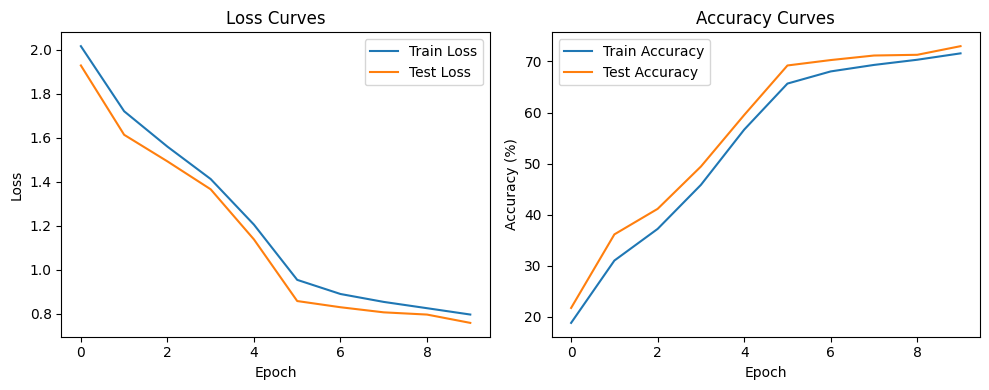

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Hyperparameters & Settings
# -------------------------------------------------------
batch_size = 64
num_epochs = 10
learning_rate = 0.001
lr_step_size = 5
lr_gamma = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------------------------------
# Data Loading and Augmentation
# -------------------------------------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# -------------------------------------------------------
# VGG16 Model Definition with Dropout and BatchNorm
# -------------------------------------------------------
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        # VGG16-like architecture adapted for 32x32 input (CIFAR-10)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = VGG16(num_classes=10).to(device)

# -------------------------------------------------------
# Loss Function, Optimizer, Learning Rate Scheduler
# -------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

# -------------------------------------------------------
# Training and Evaluation
# -------------------------------------------------------
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Optional: print progress every few batches
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy_epoch = 100. * correct / total
    train_losses.append(train_loss_epoch)
    train_acc.append(train_accuracy_epoch)

    model.eval()
    correct = 0
    total = 0
    test_loss_epoch = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss_epoch += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss_epoch = test_loss_epoch / len(test_loader)
    test_accuracy_epoch = 100. * correct / total
    test_losses.append(test_loss_epoch)
    test_acc.append(test_accuracy_epoch)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss_epoch:.4f} Train Acc: {train_accuracy_epoch:.2f}% | '
          f'Test Loss: {test_loss_epoch:.4f} Test Acc: {test_accuracy_epoch:.2f}%')

# -------------------------------------------------------
# Plotting Loss Curves
# -------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

This Python script implements a training pipeline for a custom adaptation of the **VGG16** neural network architecture on the **CIFAR-10 dataset** using PyTorch. Here's a detailed breakdown of the code:

---

### **1. Importing Libraries**
```python
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
```
- **`torch`**: Main PyTorch library for tensor operations.
- **`torch.nn`**: Provides neural network layers and loss functions.
- **`torch.optim`**: Contains optimization algorithms.
- **`torchvision`**: Provides datasets and data augmentation utilities.
- **`StepLR`**: Scheduler for learning rate adjustment.
- **`matplotlib.pyplot`**: Used for plotting results (e.g., loss and accuracy).

---

### **2. Hyperparameters and Device Setup**
```python
batch_size = 64
num_epochs = 10
learning_rate = 0.001
lr_step_size = 5
lr_gamma = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```
- **Hyperparameters**:
  - `batch_size`: Number of samples processed before model updates.
  - `num_epochs`: Total number of iterations over the dataset.
  - `learning_rate`: Initial learning rate for the optimizer.
  - `lr_step_size` & `lr_gamma`: Parameters for learning rate scheduling (decay every 5 epochs by a factor of 0.1).
- **Device**: Automatically uses a GPU if available; otherwise, defaults to CPU.

---

### **3. Data Loading and Augmentation**
#### **Transforms**
```python
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```
- **Training Augmentations**:
  - `RandomHorizontalFlip`: Randomly flips images horizontally.
  - `RandomCrop`: Randomly crops images with padding to augment the dataset.
- **Normalization**:
  - The mean and standard deviation values are specific to the CIFAR-10 dataset.
  - Images are scaled to standardize the input.

#### **Dataset and DataLoader**
```python
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
```
- CIFAR-10 dataset is loaded and transformed.
- **DataLoaders**: Handle batching and shuffling of data for training (`shuffle=True`) and evaluation (`shuffle=False`).

---

### **4. VGG16 Model Definition**
The `VGG16` class defines a convolutional neural network inspired by the VGG16 architecture, modified for the CIFAR-10 dataset.
```python
class VGG16(nn.Module):
    ...
```
- **`features`**: Contains convolutional and pooling layers grouped into blocks.
- **`classifier`**: Fully connected layers with dropout for regularization.
- **Forward Pass**:
  - Input flows through the `features` to extract patterns.
  - Flattened output passes through the `classifier` for final class predictions.

---

### **5. Loss Function, Optimizer, and Scheduler**
```python
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
```
- **CrossEntropyLoss**: Suitable for multi-class classification.
- **Adam Optimizer**: Adaptive optimization technique.
- **StepLR**: Decays the learning rate every `lr_step_size` epochs.

---

### **6. Training and Evaluation Loop**
#### **Training Phase**
```python
for epoch in range(num_epochs):
    model.train()
    ...
    for i, (images, labels) in enumerate(train_loader):
        ...
        loss.backward()
        optimizer.step()
```
- Iterates over batches of data, computes gradients, and updates weights.
- Tracks running loss and accuracy for the epoch.

#### **Evaluation Phase**
```python
    model.eval()
    ...
    with torch.no_grad():
        for images, labels in test_loader:
            ...
```
- Uses `torch.no_grad()` to disable gradient computation during evaluation.
- Calculates test loss and accuracy.

#### **Scheduler Update**
```python
    scheduler.step()
```
- Reduces the learning rate according to the decay schedule.

---

### **7. Plotting Loss and Accuracy**
```python
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
...
plt.tight_layout()
plt.show()
```
- Visualizes the training and testing loss and accuracy trends over epochs.

---

### **Overall Workflow**
1. **Dataset Preparation**: CIFAR-10 data is augmented, normalized, and batched.
2. **Model**: A VGG16-like architecture with dropout and batch normalization.
3. **Training**: Optimizes the model using backpropagation.
4. **Evaluation**: Assesses model performance on test data.
5. **Visualization**: Plots loss and accuracy trends to monitor learning progress.



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Train Loss: 1.9863, Val Loss: 1.9093, Val Acc: 23.34%
Epoch [2/20], Train Loss: 1.6224, Val Loss: 1.5807, Val Acc: 39.58%
Epoch [3/20], Train Loss: 1.3829, Val Loss: 1.3893, Val Acc: 46.62%
Epoch [4/20], Train Loss: 1.1693, Val Loss: 1.0871, Val Acc: 61.03%
Epoch [5/20], Train Loss: 0.9999, Val Loss: 0.9261, Val Acc: 68.23%
Epoch [6/20], Train Loss: 0.8694, Val Loss: 0.8735, Val Acc: 70.11%
Epoch [7/20], Train Loss: 0.7801, Val Loss: 0.7976, Val Acc: 73.21%
Epoch [8/20], Train Loss: 0.7080, Val Loss: 0.9084, Val Acc: 71.01%
Epoch [9/20], Train Loss: 0.6584, Val Loss: 0.6824, Val Acc: 77.58%
Epoch [10/20], Train Loss: 0.6019, Val Loss: 0.6118, Val Acc: 80.70%
Epoch [11/20], Train Loss: 0.4691, Val Loss: 0.4885, Val Acc: 83.85%
Epoch [12/20], Train Loss: 0.4331, Val Loss: 0.4687, Val Acc: 84.61%
Epoch [13/20], Train Loss: 0.4133, Val Loss: 0.4664, Val Acc: 84.70%
Epoch [14/20], Train Loss: 0.3993, V

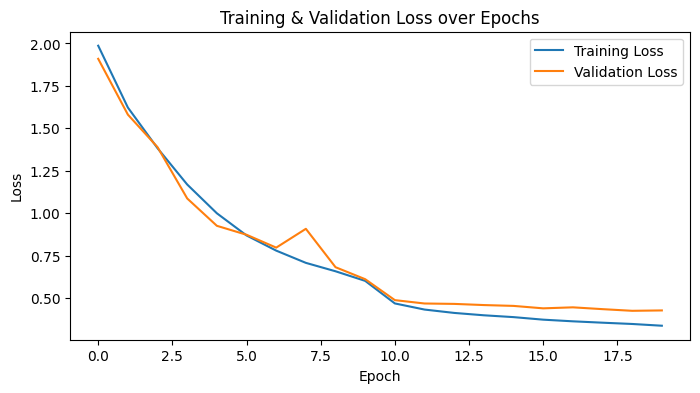

In [2]:
######################################################################
# Step-by-Step VGG-16 Implementation with Training and Visualization
######################################################################
# This example uses PyTorch, CIFAR-10 as dataset, demonstrates VGG16 from scratch,
# batch normalization, dropout, Adam optimizer, learning rate scheduling, and
# training loss visualization.

#---------------------------
# Step 1: Imports and Setup
#---------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#---------------------------
# Step 2: Define Transform and Load Dataset
#---------------------------
# CIFAR-10: 32x32 RGB images in 10 classes
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

#---------------------------
# Step 3: Define VGG-16 Architecture
#---------------------------
# VGG16 originally does not include BatchNorm, but we will add it here to show its impact.
# We'll also add Dropout to show its effect.

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        # VGG-16 consists of several convolutional blocks:
        # (Conv3x3 layers + ReLU) repeated, then MaxPool, and so on.

        # Block 1
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)

        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)

        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_3 = nn.BatchNorm2d(256)

        # Block 4
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_3 = nn.BatchNorm2d(512)

        # Block 5
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512)

        # Fully connected layers
        self.fc1 = nn.Linear(512, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = F.relu(self.bn3_3(self.conv3_3(x)))
        x = self.pool(x)

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = F.relu(self.bn4_3(self.conv4_3(x)))
        x = self.pool(x)

        # Block 5
        x = F.relu(self.bn5_1(self.conv5_1(x)))
        x = F.relu(self.bn5_2(self.conv5_2(x)))
        x = F.relu(self.bn5_3(self.conv5_3(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = VGG16(num_classes=10).to(device)

#---------------------------
# Step 4: Define Loss and Optimizer
#---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#---------------------------
# Step 5: Define a Learning Rate Scheduler
#---------------------------
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#---------------------------
# Step 6: Training Loop
#---------------------------
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate():
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return val_loss / len(test_loader), 100.*correct/total

num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

start_time = time.time()
for epoch in range(num_epochs):
    train_loss = train_one_epoch(epoch)
    val_loss, val_acc = validate()
    scheduler.step() # Update learning rate as per the scheduler

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
end_time = time.time()
print("Training complete in: {:.2f} seconds".format(end_time - start_time))

#---------------------------
# Step 7: Plot Loss Curves
#---------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training & Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

This Python script demonstrates a step-by-step implementation of a modified **VGG-16 architecture** for training on the **CIFAR-10 dataset**. The code includes data augmentation, model definition, training, validation, and visualization of loss and accuracy trends.

---

### **Code Walkthrough**

#### **1. Step 1: Imports and Setup**
```python
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
```
- **Libraries**:
  - `torch` and `torchvision`: Core libraries for building models, datasets, and data augmentation.
  - `matplotlib.pyplot`: For visualizing results.
  - `time`: To measure training duration.

- **Device Setup**:
```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```
- Automatically chooses GPU if available; otherwise, defaults to CPU.

---

#### **2. Step 2: Data Transformations and Loading**
```python
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])
```
- **Data Augmentation**:
  - Random horizontal flips and cropping to increase data diversity.
  - Normalization: Standardizes image pixel values using mean and standard deviation specific to CIFAR-10.

- **Datasets and DataLoaders**:
```python
train_dataset = torchvision.datasets.CIFAR10(...)
test_dataset = torchvision.datasets.CIFAR10(...)
train_loader = DataLoader(train_dataset, batch_size=128, ...)
test_loader = DataLoader(test_dataset, batch_size=128, ...)
```
- `DataLoader`: Handles batching, shuffling, and parallel loading.

---

#### **3. Step 3: VGG-16 Model Architecture**
```python
class VGG16(nn.Module):
    ...
```
- **Modified VGG-16**:
  - Incorporates **Batch Normalization** after each convolution to stabilize training and speed up convergence.
  - Includes **Dropout** layers (probability = 0.5) in the fully connected layers for regularization.

- **Blocks**:
  - Five blocks, each containing:
    - Two or three `Conv2d` layers with ReLU activations.
    - Batch normalization after each convolution.
    - A `MaxPool2d` layer at the end to downsample the feature maps.

- **Fully Connected Layers**:
  - `fc1` → `fc2` → `fc3` with ReLU and Dropout between `fc1` and `fc2`.

- **Forward Pass**:
  - Input sequentially flows through convolutional blocks.
  - Flattened before passing through the fully connected layers.

---

#### **4. Step 4: Loss Function and Optimizer**
```python
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```
- **CrossEntropyLoss**: Suitable for classification tasks.
- **Adam Optimizer**: Adaptive learning rate optimization algorithm.

---

#### **5. Step 5: Learning Rate Scheduler**
```python
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
```
- Reduces the learning rate by a factor of `gamma` (0.1) every `step_size` (10 epochs).

---

#### **6. Step 6: Training and Validation Loops**
```python
def train_one_epoch(epoch):
    ...
```
- **Training**:
  - Loops over batches of training data.
  - Performs forward pass, computes loss, and updates weights using backpropagation.
  - Tracks running loss.

```python
def validate():
    ...
```
- **Validation**:
  - Model is evaluated on test data (without gradient computation).
  - Computes validation loss and accuracy.

```python
for epoch in range(num_epochs):
    ...
```
- Executes training and validation for the specified number of epochs.
- Updates the learning rate at the end of each epoch using the scheduler.

---

#### **7. Step 7: Visualization**
```python
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
...
```
- Loss curves for training and validation are plotted to observe trends and check for overfitting/underfitting.

---

### **Key Features**
1. **VGG-16 Architecture**:
   - Implements convolutional blocks with Batch Normalization.
   - Fully connected layers use Dropout for regularization.

2. **Data Augmentation**:
   - Horizontal flipping and cropping to improve generalization.

3. **Learning Rate Scheduling**:
   - Dynamically adjusts the learning rate to maintain efficient training.

4. **Validation Loop**:
   - Periodic evaluation ensures proper tracking of model performance.

5. **Visualization**:
   - Plots enable easy monitoring of loss trends and model behavior.

---

### **Output**
- **Training & Validation Loss Curve**:
  - Indicates convergence of the model.
- **Validation Accuracy**:
  - Demonstrates generalization performance on unseen data.
- **Training Duration**:
  - Total time taken for training is printed.